In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio
from pypfm import PFMLoader
np.set_printoptions(formatter={"float": "{:10.2f}".format})

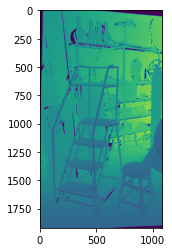

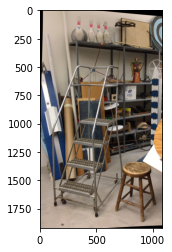

In [3]:
img_path = "/home/julian/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "/home/julian/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

loader = PFMLoader(color=False, compress=False)
pfm = loader.load_pfm(dispm_path)

for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        Z = baseline * f / (disp + doffs)
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0)

im = imageio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm,origin="upper")

plt.figure()
plt.imshow(im)


In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [5]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, eye_dome_lighting=True)

In [126]:
from src.dmcpworkflow.annotate_points import annotate

%matplotlib
cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(cps)

Using matplotlib backend: TkAgg
[[    340.54      74.95     348.29      80.12]
 [    596.35     268.75     586.01     289.42]
 [    366.38     989.67     374.13     992.25]
 [    433.56    1625.32     425.81    1640.82]
 [    175.16    1573.64     180.33    1581.39]
 [    896.08    1591.73     893.50    1586.56]]


In [127]:
#cps[:,2:] = cps[:,:2]

In [128]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

In [129]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = cam @ ext

world_pts = dm_to_world(dm, cam, P,cps[:,2:])
world_pts

array([[  -2550.09,   -4746.24,    9377.90],
       [  -1396.21,   -3991.51,   10357.24],
       [  -1966.25,     153.13,    7650.17],
       [  -1467.64,    2545.73,    6459.33],
       [  -2530.16,    2468.63,    6860.43],
       [    267.13,    2277.40,    6276.99]], dtype=float32)

In [130]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [131]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      1.00      -0.01      -0.02     179.16]
 [      0.01       1.00       0.01     -15.06]
 [      0.02      -0.01       1.00      79.39]]
A
[[      0.65       0.67      -0.36     -24.80]
 [      0.31       0.20       0.93     119.90]
 [      0.70      -0.71      -0.07      65.87]
 [      0.00       0.00       0.00       1.00]]


In [132]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([    179.16,     -15.06,      79.39])

dmcp works with arbitrary transformation 

In [133]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

#### test the same for custom depth map

In [148]:
from src.dmcpworkflow.capture_depth import generate_depth_map

tup = generate_depth_map(mesh)

[[   1196.27       0.00     512.00]
 [      0.00     897.20     384.00]
 [      0.00       0.00       1.00]]


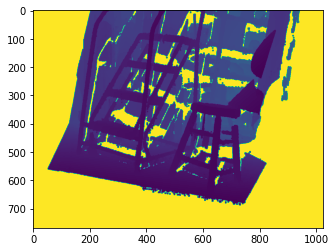

In [149]:
_dm, _dmK, _dmP = tup

print(_dmK)

plt.imshow(_dm)
plt.show()

In [150]:
%matplotlib
cps = annotate(im[:,:,0],_dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(cps)

Using matplotlib backend: TkAgg
[[    733.30    1527.13     554.17     420.21]
 [    694.54    1677.00     514.25     517.93]
 [    901.25    1751.93     636.75     579.87]
 [    890.92    1581.39     650.51     446.36]
 [    973.60    1532.30     717.95     467.01]
 [   1002.03    1669.24     724.83     566.11]]


In [151]:
world_pts = dm_to_world(_dm, _dmK, _dmP,cps[:,2:])
world_pts

array([[   -285.76,    2249.16,    6459.64],
       [   -430.88,    3013.71,    6737.76],
       [    352.52,    3272.26,    6289.75],
       [    275.28,    2349.66,    6279.98],
       [    634.45,    2438.71,    6914.39],
       [    790.01,    3184.63,    7080.29]], dtype=float32)

In [152]:
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [153]:
A = dmcp(_dmK, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      0.94      -0.24      -0.24    2165.29]
 [      0.03       0.77      -0.64       7.16]
 [      0.34       0.60       0.73   -4593.60]]
A
[[      0.39       0.73      -0.56    2047.11]
 [     -0.13       0.64       0.75    4939.80]
 [      0.91      -0.23       0.35     -79.89]
 [      0.00       0.00       0.00       1.00]]


In [154]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([   2270.93,    4840.29,     -81.12])

In [155]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()